In [1]:
import pandas as pd
import os
from qc_metrics import extract_af_metrics
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
RECEPTOR_CSV_PATH = 'data/human_receptors.csv'
PREDICTION_DIR = '../predictions_pdb_benchmark'

In [3]:
df_receptors = pd.read_csv(RECEPTOR_CSV_PATH)
df_receptors = df_receptors.loc[~df_receptors['is_single_tm']]
df_receptors = df_receptors.loc[df_receptors['Sequence'].str.len()<=2000]
df_receptors.shape

(1112, 6)

#### Load all the predictions. We use parallel processing, use `n_jobs` for control of resource usage.

In [4]:
# list all predictions
predictions = os.listdir(PREDICTION_DIR)

n_jobs = 35
with ProcessPoolExecutor(n_jobs) as executor:
    jobs = {}
    for f in tqdm(predictions, leave=False):
        p = os.path.join(PREDICTION_DIR, f)
        file_protein_id = p.split('/')[-1].split('_')[0]
        if file_protein_id not in df_receptors['protein_id'].values:
            continue

        topology = df_receptors.loc[df_receptors['protein_id']==file_protein_id].iloc[0]['Topology']

        job = executor.submit(extract_af_metrics,p, receptor_chains = [0], ligand_chains = [1], receptor_topology_string=topology, relaxed=False, pred_is_nested=False)

        jobs[p] = job

    failed_runs = []
    res = []
    for p, job in tqdm(jobs.items(), leave=True):
        if job.exception() is not None:
            print(p)
            print(job.exception())
            continue
            
        df = job.result()
        if len(df) == 0:
            failed_runs.append(p)
            continue

        s = df.reset_index() # make a new column that contains 1,2,3,4,5 model num
        s['pred_folder'] = df['pred_folder'][0].split('/')[-1]
            
        res.append(s)

df = pd.concat(res)

tmp = df['pred_folder'].str.split('_', expand=True)
df['receptor'] = tmp[0]
df['peptide'] = tmp[1]
df = df.set_index(['peptide', 'receptor', 'index'])

  0%|          | 0/13850 [00:00<?, ?it/s]

In [9]:
# Loading is heavy, so checkpoint the output.
df.to_pickle('tempsave_raw_df.pkl')

In [4]:
df = pd.read_pickle('tempsave_raw_df.pkl')

In [5]:
df.sort_index().to_csv('results/pdb_benchmark_raw.csv')

#### Pool the five predictions for ranking.

In [6]:
df = pd.read_csv('results/pdb_benchmark_raw.csv', index_col=[0,1,2])

def compute_mad(x):
    return np.median(np.absolute(x - np.median(x)))

df_mad = df.groupby(level=[0,1]).agg(compute_mad)
df_median = df.groupby(level=[0,1]).agg('median')

df_lowerbound = df_median - df_mad
df_lowerbound['PAE'] = df_median['PAE'] + df_mad['PAE'] #PAE low is better
df_lowerbound['contacts_outside'] = df_median['contacts_outside']
df_lowerbound['contacts_inside'] =df_median['contacts_inside']


/tmp/ipykernel_39507/1396277538.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  df_mad = df.groupby(level=[0,1]).agg(compute_mad)


In [7]:
def get_ranks(df, true_name, percentiles=True, outside_only=True):
    '''Converts each metric to ranks, and handles DeepTMHMM topology filtering.'''
    df = df.copy()
    # mask by contacts
    if outside_only:
        df.loc[df['contacts_outside']==0, 'PAE'] = 1000
        df.loc[df['contacts_outside']==0, 'plddt_ligand'] = -1000
        df.loc[df['contacts_outside']==0, 'ranking_confidence'] = -1000
        df.loc[df['contacts_outside']==0, 'pdockq'] = -1000

        df.loc[df['contacts_outside']==0, 'ptm'] = -1000
        df.loc[df['contacts_outside']==0, 'iptm'] = -1000

    out = pd.Series({
        'PAE': df['PAE'].rank(ascending=True, pct=percentiles)[true_name],
        'plddt': df['plddt_ligand'].rank(ascending=False, pct=percentiles)[true_name],
        'ranking_confidence': df['ranking_confidence'].rank(ascending=False, pct=percentiles)[true_name],
        'pdockq': df['pdockq'].rank(ascending=False, pct=percentiles)[true_name],
        'ptm': df['ptm'].rank(ascending=False, pct=percentiles)[true_name],
        'iptm': df['iptm'].rank(ascending=False, pct=percentiles)[true_name],
    })
    out.name = 'percentile' if percentiles else 'rank'

    return out * (100 if percentiles else 1) # is percent

In [9]:
# define true pairs and nice peptide/receptor names for plotting.
complexes = {
    'Secretin - SECR': 'P47872_P09683:28-54',
    'Galanin - GALR1': 'P47211_P22466:33-62',
    'Galanin - GALR2': 'O43603_P22466:33-62',
    'Oxytocin - OXYR': 'P30559_P01178:20-28',
    'Cholecystokinin-8 - CCKAR': 'P32238_P06307:96-103',
    'Somatostatin-14 - SSR2': 'P30874_P61278:103-116',
    'Neuropeptide Y - NPYR': 'P25929_P01303:29-64',
    'Ghrelin-27 - GHSR': 'Q92847_Q9UBU3:24-50',
    'Substance P - NK1R': 'P25103_P20366:58-68',
    'Somatoliberin - Q9HB45': 'Q9HB45_P01286:32-75',
    'Gastrin-17 - GASR': 'P32239_P01350:76-92',
}

# split, invert result, convert to pep_id -> rec_id dict
true_pairs = dict([x.split('_')[::-1] for x in complexes.values()])

In [10]:
# Make ranks for each peptide-receptor pair.
results_deeptmhmm = []
results_nodeeptmhmm = []
for pep, df in df_lowerbound.groupby(level=0):
    true_receptor = true_pairs[pep]
    percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True)
    percentiles.name = pep + '_' + true_receptor
    results_deeptmhmm.append(percentiles)

    percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True,outside_only=False)
    percentiles.name = pep + '_' + true_receptor
    results_nodeeptmhmm.append(percentiles)

    if pep == 'P22466:33-62': #special handling because there are 2 receptors for the same peptide and our dict doesn't reflect that after inversion.
        true_receptor = 'P47211'
        percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True)
        percentiles.name = pep + '_' + true_receptor
        results_deeptmhmm.append(percentiles)

        percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True,outside_only=False)
        percentiles.name = pep + '_' + true_receptor
        results_nodeeptmhmm.append(percentiles)


Text(0, 0.5, 'Confidence metric for ranking receptors')

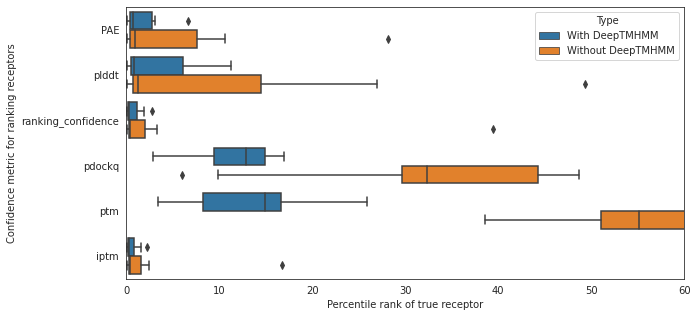

In [11]:
df_with = pd.DataFrame(results_deeptmhmm).melt(ignore_index=False)
df_with['Type'] = 'With DeepTMHMM'
df_without = pd.DataFrame(results_nodeeptmhmm).melt(ignore_index=False)
df_without['Type'] = 'Without DeepTMHMM'

fig = plt.figure(figsize = (10,5))
#pd.concat([df_with, df_without])#.plot.box(by='Type', rot=90)

#sns.violinplot(data=pd.concat([df_with, df_without]), x='variable', y='value', hue='Type', cut=0, inner='point')p
sns.set_style('white')
sns.boxplot(data=pd.concat([df_with, df_without]), y='variable', x='value', hue='Type')
#sns.swarmplot(data=pd.concat([df_with, df_without]), x='variable', y='value', hue='Type')
plt.xlim(0,60)
plt.xlabel('Percentile rank of true receptor')
plt.ylabel('Confidence metric for ranking receptors')

#### Make the percentile rank tables.

In [12]:
# With DeepTMHMM
table_for_paper = df_with.reset_index().pivot_table(values='value', columns='variable', index='index')
rename_dict = dict(zip(['_'.join(x.split('_')[::-1]) for x in complexes.values()], complexes.keys()))
table_for_paper.index = [rename_dict[x] for x in table_for_paper.index]
table_for_paper.round(2).sort_index()

variable,PAE,iptm,pdockq,plddt,ptm,ranking_confidence
Cholecystokinin-8 - CCKAR,0.74,0.09,6.03,2.11,17.45,0.09
Galanin - GALR1,0.10,0.09,12.86,0.10,3.42,0.09
Galanin - GALR2,0.48,0.27,17.00,0.58,9.35,0.27
Gastrin-17 - GASR,2.82,1.08,9.71,7.87,15.20,1.71
Ghrelin-27 - GHSR,2.77,0.72,15.92,4.48,7.64,0.45
Neuropeptide Y - NPYR,0.49,0.36,2.88,0.88,4.50,0.36
Oxytocin - OXYR,6.62,1.62,13.40,11.28,19.15,1.89
Secretin - SECR,1.29,0.36,9.44,0.50,15.92,0.36
Somatoliberin - Q9HB45,0.39,0.63,9.53,0.58,14.93,0.63
Somatostatin-14 - SSR2,0.10,0.09,15.29,0.69,8.99,0.09


In [13]:
table_for_paper.mean()

variable
PAE                    1.719827
iptm                   0.686723
pdockq                11.510791
plddt                  3.438222
ptm                   12.949640
ranking_confidence     0.793002
dtype: float64

In [14]:
# Without DeepTMHMM
table_for_paper = df_without.reset_index().pivot_table(values='value', columns='variable', index='index')
rename_dict = dict(zip(['_'.join(x.split('_')[::-1]) for x in complexes.values()], complexes.keys()))
table_for_paper.index = [rename_dict[x] for x in table_for_paper.index]
table_for_paper.round(2).sort_index()

variable,PAE,iptm,pdockq,plddt,ptm,ranking_confidence
Cholecystokinin-8 - CCKAR,0.91,0.09,6.03,2.40,68.17,0.18
Galanin - GALR1,0.10,0.09,29.77,0.10,38.58,0.09
Galanin - GALR2,0.50,0.36,48.74,0.60,53.69,0.27
Gastrin-17 - GASR,28.21,16.73,46.40,49.30,76.62,39.48
Ghrelin-27 - GHSR,10.62,1.53,44.78,12.72,49.37,1.62
Neuropeptide Y - NPYR,0.51,0.36,9.89,1.03,46.31,0.36
Oxytocin - OXYR,8.01,1.71,32.37,26.94,66.46,2.43
Secretin - SECR,7.24,0.45,43.79,0.64,66.73,0.45
Somatoliberin - Q9HB45,0.42,0.63,29.59,0.84,52.70,0.63
Somatostatin-14 - SSR2,0.32,0.36,40.92,1.28,55.13,0.36


In [15]:
table_for_paper.mean()

variable
PAE                    5.603396
iptm                   2.248201
pdockq                32.987247
plddt                 10.187772
ptm                   58.772073
ranking_confidence     4.471877
dtype: float64

#### Plot the score distributions

In [16]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('afpep', ['#CDDEF7', '#FAD996'])

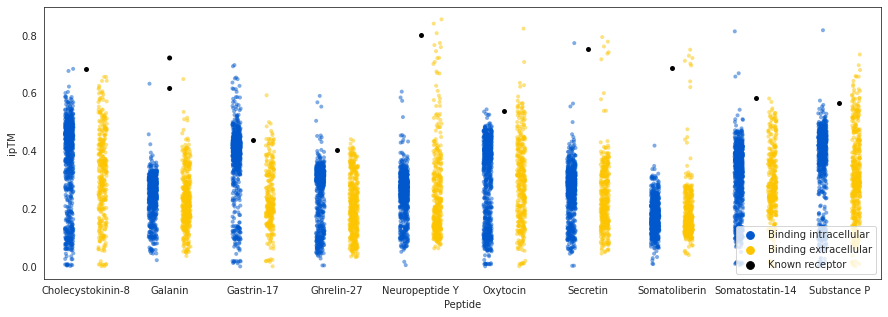

In [17]:
df_plot = df_lowerbound.copy().reset_index()
df_plot['contacts_outside'] = df_plot['contacts_outside'].fillna(0)
df_plot['peptide'] = df_plot['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

df_plot['Label'] = 'Binding intracellular'
df_plot.loc[df_plot['contacts_outside'] > 0, 'Label'] = 'Binding extracellular'
#df_top = df_plot.groupby(['peptide', 'Label']).apply(lambda x: x.nlargest(int(len(x)* 0.01), 'iptm')).reset_index(drop=True)
df_true = df_lowerbound.loc[[x.split('_')[::-1] for x in complexes.values()]].reset_index()
df_true['Label'] = 'Known receptor'
df_true['peptide'] = df_true['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

# remove true from background so no double plotting
df_plot = df_plot.set_index(['peptide', 'receptor'], drop=True).drop(df_true.set_index(['peptide', 'receptor']).index).reset_index()

plt.figure(figsize=(15,5))
sns.stripplot(data=df_plot.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, alpha=0.5, size=4, hue_order = ['Binding intracellular', 'Binding extracellular'], palette=['#0058cc', '#fcc500'])#'#9DB7DE', '#FAD997']) # 
sns.swarmplot(data=df_true.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, palette=['black'])
plt.ylabel('ipTM')
plt.xlabel('Peptide')
plt.legend(loc='lower right')

plt.savefig('iptm_scores.png',dpi=1200, bbox_inches='tight')